# 4: Extension on Classification

### Alternative implimentations

Because `scikit-learn` defines a flexible standardised interface independent packages normally impliment the same interface to make it easy to switch and find the best one for you.

`XGBoost` is one such example that is often ranked highly in machine learning competitions. Let's see how it performs in comparision to two alorithms from `scikit-learn`.

**Exercise:** This could be an exercise if you have lots of time

First load the data that we need from the previous lesson and import the modules again:

In [1]:
%store -r training_data
%store -r training_columns
%store -r mc_df
%store -r bkg_df
%store -r data_df

In [2]:
import mplhep
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from xgboost import XGBClassifier

In [3]:
def plot_comparision(var, mc_df, bkg_df):
    # create histograms
    hsig, bins = np.histogram(mc_df[var], bins=60, density=1)
    hbkg, bins = np.histogram(bkg_df[var], bins=bins, density=1)

    mplhep.histplot((hsig, bins), label='MC Signal', )
    mplhep.histplot(hbkg, bins=bins, label='Data Bkg')
    plt.xlabel(var)
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc='best')


def plot_significance(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:, 1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)

    n_sig = 1200
    n_bkg = 23000
    S = n_sig * tpr
    B = n_bkg * fpr
    metric = S / np.sqrt(S + B)

    plt.plot(thresholds, metric, label=label)
    plt.xlabel('BDT cut value')
    plt.ylabel('$\\frac{S}{\\sqrt{S+B}}$')
    plt.xlim(0, 1.0)

    optimal_cut = thresholds[np.argmax(metric)]
    plt.axvline(optimal_cut, color='black', linestyle='--')


def plot_roc(bdt, training_data, training_columns, label=None):
    y_score = bdt.predict_proba(training_data[training_columns])[:, 1]
    fpr, tpr, thresholds = roc_curve(training_data['catagory'], y_score)
    area = auc(fpr, tpr)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    if label:
        plt.plot(fpr, tpr, label=f'{label} (area = {area:.2f})')
    else:
        plt.plot(fpr, tpr, label=f'ROC curve (area = {area:.2f})')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    # We can make the plot look nicer by forcing the grid to be square
    plt.gca().set_aspect('equal', adjustable='box')

In [4]:
# Train the Gradient Booster
bdt_1 = GradientBoostingClassifier(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
bdt_1.fit(training_data[training_columns], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT'] = bdt_1.predict_proba(df[training_columns])[:, 1]

In [5]:
# Train the Adaptive Booster
bdt_2 = AdaBoostClassifier(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
bdt_2.fit(training_data[training_columns], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT_2'] = bdt_2.predict_proba(df[training_columns])[:, 1]

In [6]:
# Train XGBoost Classifier
xgboost_bdt = XGBClassifier(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
xgboost_bdt.fit(training_data[training_columns], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['XGBoost_BDT'] = xgboost_bdt.predict_proba(df[training_columns])[:, 1]

/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)
/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


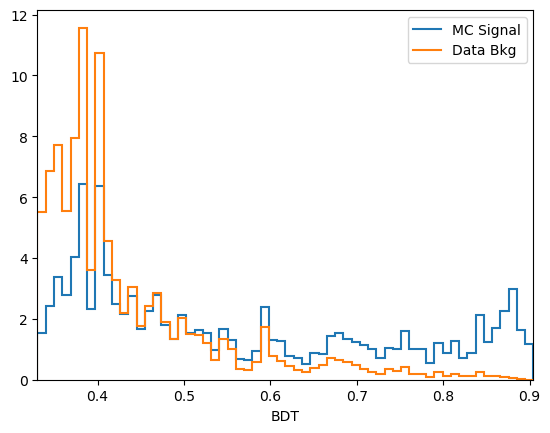

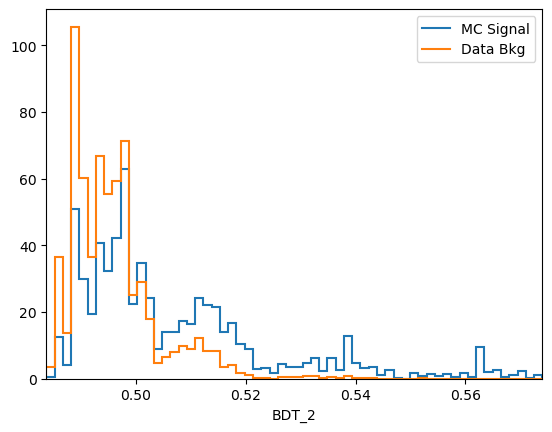

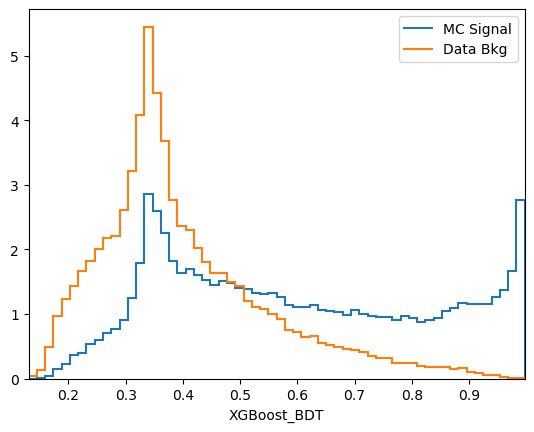

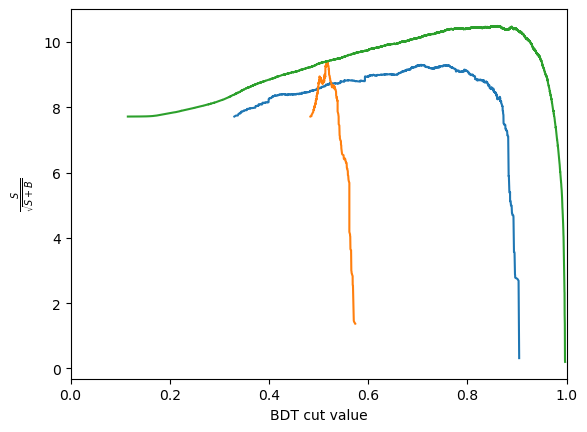

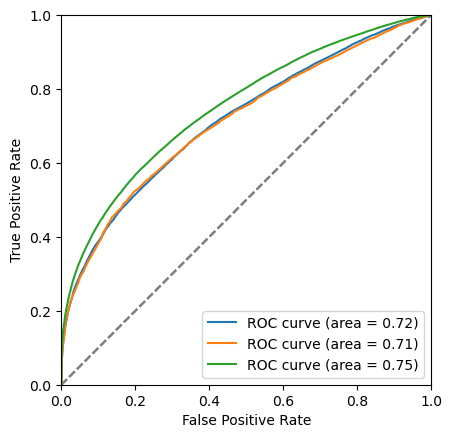

In [7]:
plt.figure()
plot_comparision('BDT', mc_df, bkg_df)
plt.figure()
plot_comparision('BDT_2', mc_df, bkg_df)
plt.figure()
plot_comparision('XGBoost_BDT', mc_df, bkg_df)

plt.figure()
for bdt in [bdt_1, bdt_2, xgboost_bdt]:
    plot_significance(bdt, training_data, training_columns)

plt.figure()
for bdt in [bdt_1, bdt_2, xgboost_bdt]:
    plot_roc(bdt, training_data, training_columns)

Comments:

- While `predict_proba` is always defined to be between 0 and 1, the actualy value is generally not very meaningful. In this case we see that the range of the AdaBoost classifier is different. More generally, the output of a classifier is _not_ a probability but something that is probability-like: there exists a bijective transformation for the output to transform it to a probability for each classifier. This however is not known in general and can be hard to find. In short: the _ranking_ matters, not the absolute value.

**Exercise:** What happens if you put mass into the BDT?
 - Avoid variables which correlated with mass
 - Variables with a little correlation is okay, such as momentum. (Assuming your resolution is good)

**Question:** What happens if real and simulated data are different?

### Feature engineering

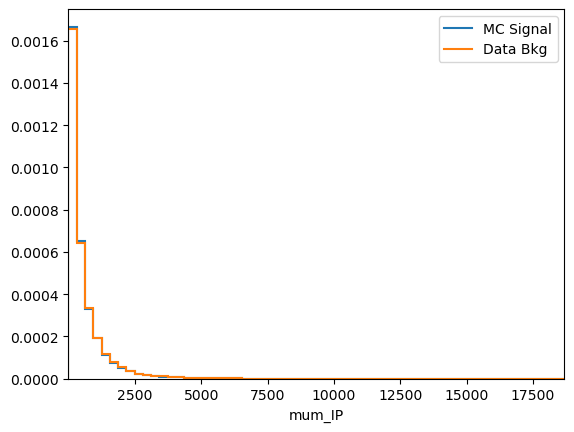

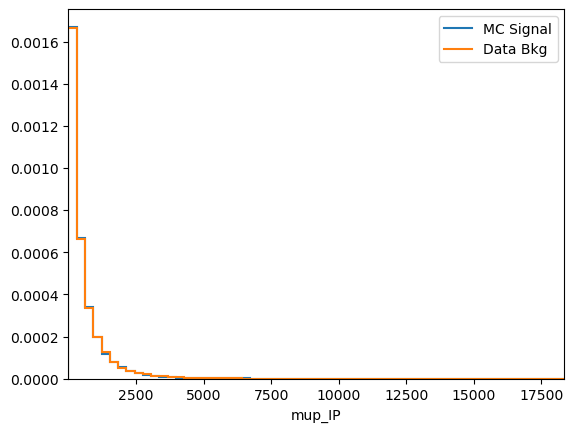

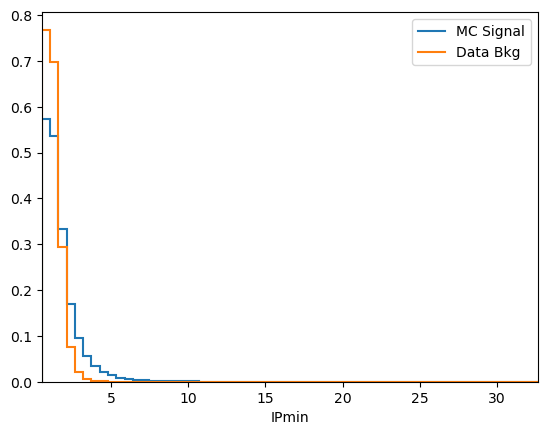

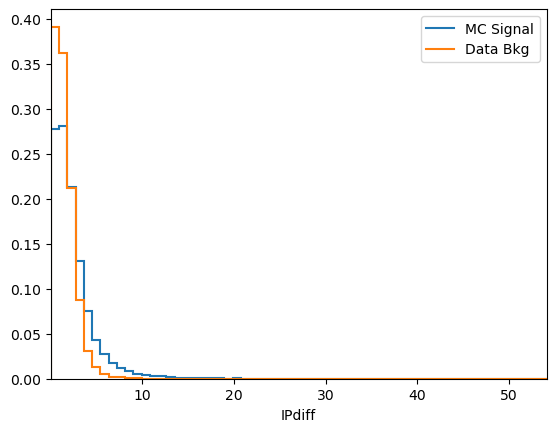

In [8]:
for df in [mc_df, bkg_df, data_df, training_data]:
    df['IPmin'] = np.min([df['mum_PT'], df['mup_PT']], axis=0)

for df in [mc_df, bkg_df, data_df, training_data]:
    df['IPdiff'] = np.abs(df['mum_PT'] - df['mup_PT'])

plt.figure()
plot_comparision('mum_IP', mc_df, bkg_df)

plt.figure()
plot_comparision('mup_IP', mc_df, bkg_df)

plt.figure()
plot_comparision('IPmin', mc_df, bkg_df)

plt.figure()
plot_comparision('IPdiff', mc_df, bkg_df)

See how much better the BDT performs when our new variable is included

/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)
/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


/tmp/ipykernel_4672/2193470804.py:21: RuntimeWarning: invalid value encountered in divide
  metric = S / np.sqrt(S + B)


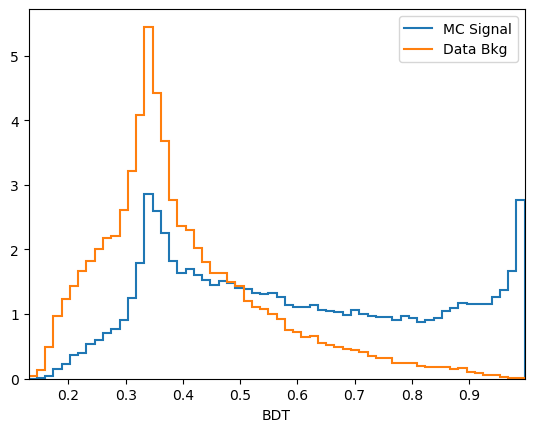

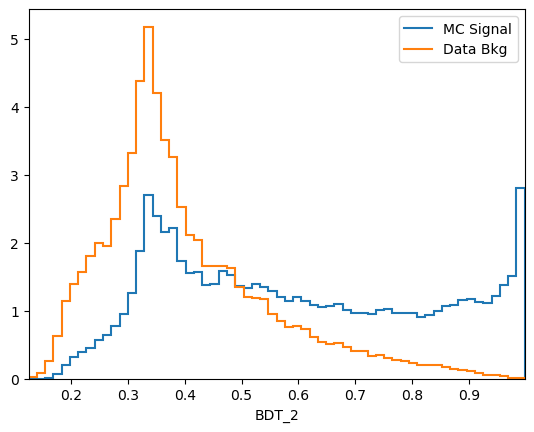

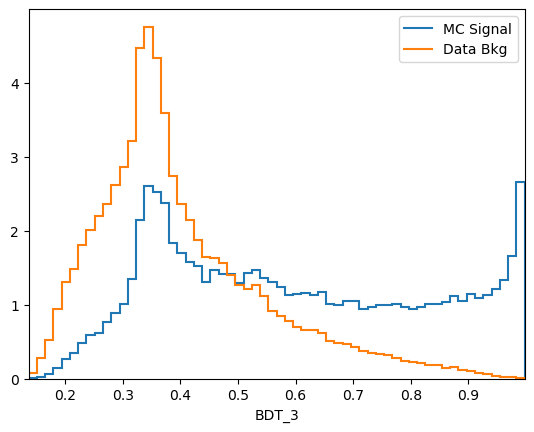

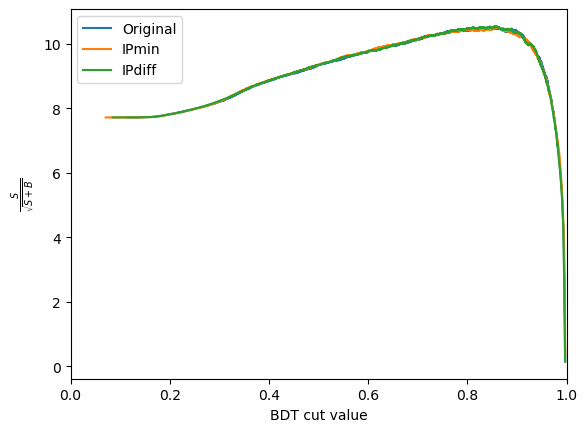

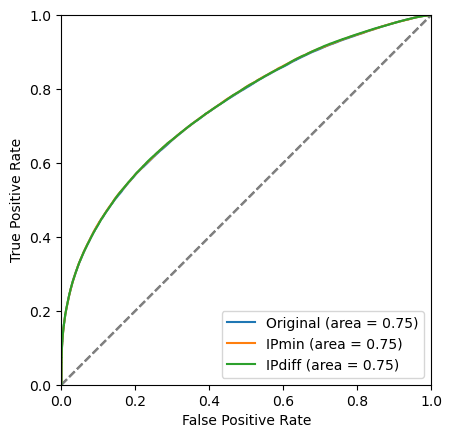

In [9]:
# bdtclass = GradientBoostingClassifier()
bdtclass = XGBClassifier  # we could also use this one
bdt_1 = bdtclass(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
bdt_1.fit(training_data[training_columns], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT'] = bdt_1.predict_proba(df[training_columns])[:, 1]

bdt_2 = bdtclass(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
training_columns_2 = training_columns + ['IPmin']
bdt_2.fit(training_data[training_columns_2], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT_2'] = bdt_2.predict_proba(df[training_columns_2])[:, 1]

bdt_3 = bdtclass(n_estimators=20)  # less estimator is faster, for demonstration, but 100-300 is usually better
training_columns_3 = training_columns + ['IPdiff']
bdt_3.fit(training_data[training_columns_3], training_data['catagory'])
for df in [mc_df, bkg_df, data_df, training_data]:
    df['BDT_3'] = bdt_3.predict_proba(df[training_columns_3])[:, 1]

plt.figure()
plot_comparision('BDT', mc_df, bkg_df)
plt.figure()
plot_comparision('BDT_2', mc_df, bkg_df)
plt.figure()
plot_comparision('BDT_3', mc_df, bkg_df)

plt.figure()
plot_significance(bdt_1, training_data, training_columns, label='Original')
plot_significance(bdt_2, training_data, training_columns_2, label='IPmin')
plot_significance(bdt_3, training_data, training_columns_3, label='IPdiff')
plt.legend()

plt.figure()
plot_roc(bdt_1, training_data, training_columns, label='Original')
plot_roc(bdt_2, training_data, training_columns_2, label='IPmin')
plot_roc(bdt_3, training_data, training_columns_3, label='IPdiff')
plt.legend()

### $k$-folding

This is a technique to avoid losing some parts of your data by splitting it into test and training set. It is crucial e.g. in the scenario where a part of your training data _needs predictions_ such as when a sideband is used as the background.

![k-folding](https://miro.medium.com/max/601/1*PdwlCactbJf8F8C7sP-3gw.png)

The red tiles are used as a training set in order to predict the blue ones. This is done k times, resulting in k prediction for the k tiles we split into. We end up having predictions for our whole dataset!

The validation is a holdout part of the data that we can use to estimate our actual performance. When we optimize our algorithm, we may overfit to the given dataset and overestimate our performance. By evaluating our "best" algorithm on a dataset that has not yet been seen at all, we get an unbiased estimate.

Let's go search for `scikit learn k-folding`.

 - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

Look at the example section:

```python
>>> from sklearn.model_selection import KFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([1, 2, 3, 4])
>>> kf = KFold(n_splits=2)
>>> kf.get_n_splits(X)
2
>>> print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in kf.split(X):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]
```

**Exercise**: Implement the above training for your favoride classifier in K-folding with k = 10

### Turn this into a scipt using argparse